# 📘 NOTEBOOK 2: WRITING DATA IN PYSPARK

## Topics Covered:
- Writing to different formats (CSV, JSON, Parquet, ORC)
- Write modes (overwrite, append, ignore, error)
- Partitioning strategies
- Compression options
- Performance optimization
- Best practices

## 1. Setup Spark Session with MinIO

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
import time
import builtins

spark = SparkSession.builder \
    .appName("02-Writing-Data") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000") \
    .config("spark.hadoop.fs.s3a.access.key", "minioadmin") \
    .config("spark.hadoop.fs.s3a.secret.key", "minioadmin123") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()

print("✅ Spark Session Created")
print(f"   Spark Version: {spark.version}")
print(f"   Application ID: {spark.sparkContext.applicationId}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/03 14:40:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


✅ Spark Session Created
   Spark Version: 3.5.1
   Application ID: local-1767451218565


## 2. Create Sample Dataset

In [6]:
print("="*80)
print("📊 CREATING SAMPLE DATASET")
print("="*80)

from datetime import datetime, timedelta
import random

# Generate sample data
data = []
start_date = datetime(2024, 1, 1)
categories = ["Electronics", "Clothing", "Food", "Books", "Toys"]
cities = ["Hanoi", "HCM", "Danang", "Haiphong", "Cantho"]

for i in range(10000):
    data.append({
        "order_id": f"ORD{i:06d}",
        "customer_id": f"CUST{random.randint(1, 1000):04d}",
        "product_name": f"Product_{random.randint(1, 100)}",
        "category": random.choice(categories),
        "quantity": random.randint(1, 10),
        "price": builtins.round(random.uniform(10, 1000), 2),
        "city": random.choice(cities),
        "order_date": (start_date + timedelta(days=random.randint(0, 365))).strftime("%Y-%m-%d"),
        "status": random.choice(["completed", "pending", "cancelled"])
    })

# Create DataFrame
df = spark.createDataFrame(data)

# Add calculated columns
df = df.withColumn("total_amount", col("quantity") * col("price")) \
       .withColumn("year", year(col("order_date"))) \
       .withColumn("month", month(col("order_date"))) \
       .withColumn("day", dayofmonth(col("order_date")))

print(f"✅ Created DataFrame with {df.count():,} rows")
df.printSchema()
df.show(5)

📊 CREATING SAMPLE DATASET


✅ Created DataFrame with 10,000 rows
root
 |-- category: string (nullable = true)
 |-- city: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_date: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- price: double (nullable = true)
 |-- product_name: string (nullable = true)
 |-- quantity: long (nullable = true)
 |-- status: string (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)

+--------+--------+-----------+----------+---------+------+------------+--------+---------+------------+----+-----+---+
|category|    city|customer_id|order_date| order_id| price|product_name|quantity|   status|total_amount|year|month|day|
+--------+--------+-----------+----------+---------+------+------------+--------+---------+------------+----+-----+---+
|    Toys|Haiphong|   CUST0406|2024-09-12|ORD000000|196.28|  Product_54|       4|  p

## 3. Writing to Different Formats

In [7]:
print("="*80)
print("💾 WRITING TO DIFFERENT FORMATS")
print("="*80)

💾 WRITING TO DIFFERENT FORMATS


### 3.1 Write to CSV

In [8]:
print("\n📝 Writing to CSV...")

start_time = time.time()

df.write \
    .mode("overwrite") \
    .option("header", "true") \
    .option("sep", ",") \
    .option("quote", '"') \
    .option("escape", "\\") \
    .option("nullValue", "NULL") \
    .csv("/opt/spark-data/staging/orders_csv")

csv_time = time.time() - start_time
print(f"   ✅ CSV written in {csv_time:.2f}s")

# Verify
csv_df = spark.read.option("header", "true").csv("/opt/spark-data/staging/orders_csv")
print(f"   📊 Rows: {csv_df.count():,}")


📝 Writing to CSV...


   ✅ CSV written in 6.38s
   📊 Rows: 10,000


### 3.2 Write to JSON

In [9]:
print("\n📝 Writing to JSON...")

start_time = time.time()

df.write \
    .mode("overwrite") \
    .option("compression", "none") \
    .json("/opt/spark-data/staging/orders_json")

json_time = time.time() - start_time
print(f"   ✅ JSON written in {json_time:.2f}s")

# Verify
json_df = spark.read.json("/opt/spark-data/staging/orders_json")
print(f"   📊 Rows: {json_df.count():,}")


📝 Writing to JSON...


   ✅ JSON written in 2.17s
   📊 Rows: 10,000


### 3.3 Write to Parquet (RECOMMENDED)

In [15]:
print("\n📝 Writing to Parquet...")

start_time = time.time()

df.coalesce(4)\
    .write \
    .mode("overwrite") \
    .option("compression", "snappy") \
    .parquet("/opt/spark-data/staging/orders_parquet")

parquet_time = time.time() - start_time
print(f"   ✅ Parquet written in {parquet_time:.2f}s")

# Verify
parquet_df = spark.read.parquet("/opt/spark-data/staging/orders_parquet")
print(f"   📊 Rows: {parquet_df.count():,}")


📝 Writing to Parquet...
   ✅ Parquet written in 1.01s
   📊 Rows: 10,000


### 3.4 Write to ORC

In [11]:
print("\n📝 Writing to ORC...")

start_time = time.time()

df.write \
    .mode("overwrite") \
    .option("compression", "snappy") \
    .orc("/opt/spark-data/staging/orders_orc")

orc_time = time.time() - start_time
print(f"   ✅ ORC written in {orc_time:.2f}s")

# Verify
orc_df = spark.read.orc("/opt/spark-data/staging/orders_orc")
print(f"   📊 Rows: {orc_df.count():,}")


📝 Writing to ORC...


   ✅ ORC written in 2.95s
   📊 Rows: 10,000


### 3.5 Performance Comparison

In [16]:
print("\n" + "="*80)
print("⚡ WRITE PERFORMANCE COMPARISON")
print("="*80)

import os

def get_dir_size(path):
    """Get directory size in MB"""
    total = 0
    for entry in os.scandir(path):
        if entry.is_file():
            total += entry.stat().st_size
        elif entry.is_dir():
            total += get_dir_size(entry.path)
    return total / (1024 * 1024)  # Convert to MB

formats = {
    "CSV": ("/opt/spark-data/staging/orders_csv", csv_time),
    "JSON": ("/opt/spark-data/staging/orders_json", json_time),
    "Parquet": ("/opt/spark-data/staging/orders_parquet", parquet_time),
    "ORC": ("/opt/spark-data/staging/orders_orc", orc_time)
}

print(f"{'Format':<10} {'Time (s)':<12} {'Size (MB)':<12} {'Speed':<10}")
print("-" * 50)

for fmt, (path, write_time) in formats.items():
    size = get_dir_size(path)
    print(f"{fmt:<10} {write_time:<12.2f} {size:<12.2f} {'⚡' if write_time < 2 else '🐌'}")

print("\n💡 Key Insights:")
print("   - Parquet: Fastest + Smallest (columnar, compressed)")
print("   - ORC: Similar to Parquet (optimized for Hive)")
print("   - JSON: Slowest + Largest (human-readable)")
print("   - CSV: Medium speed, no schema preservation")


⚡ WRITE PERFORMANCE COMPARISON
Format     Time (s)     Size (MB)    Speed     
--------------------------------------------------
CSV        6.38         0.89         🐌
JSON       2.17         2.34         🐌
Parquet    1.01         0.24         ⚡
ORC        2.95         0.32         🐌

💡 Key Insights:
   - Parquet: Fastest + Smallest (columnar, compressed)
   - ORC: Similar to Parquet (optimized for Hive)
   - JSON: Slowest + Largest (human-readable)
   - CSV: Medium speed, no schema preservation


## 4. Write Modes

In [17]:
print("\n" + "="*80)
print("🔄 WRITE MODES")
print("="*80)

# Create a small test dataset
test_df = spark.createDataFrame([
    (1, "Alice", 25),
    (2, "Bob", 30),
    (3, "Charlie", 35)
], ["id", "name", "age"])

test_path = "/opt/spark-data/staging/test_modes"


🔄 WRITE MODES


### 4.1 Mode: OVERWRITE

In [18]:
print("\n1️⃣ Mode: OVERWRITE")
print("   - Deletes existing data and writes new data")

# First write
test_df.write.mode("overwrite").parquet(test_path)
print(f"   ✅ First write: {spark.read.parquet(test_path).count()} rows")

# Second write (overwrites)
test_df.limit(2).write.mode("overwrite").parquet(test_path)
print(f"   ✅ After overwrite: {spark.read.parquet(test_path).count()} rows")


1️⃣ Mode: OVERWRITE
   - Deletes existing data and writes new data
   ✅ First write: 3 rows
   ✅ After overwrite: 2 rows


### 4.2 Mode: APPEND

In [19]:
print("\n2️⃣ Mode: APPEND")
print("   - Adds new data to existing data")

# Append more data
new_df = spark.createDataFrame([
    (4, "David", 40),
    (5, "Eve", 45)
], ["id", "name", "age"])

new_df.write.mode("append").parquet(test_path)
print(f"   ✅ After append: {spark.read.parquet(test_path).count()} rows")


2️⃣ Mode: APPEND
   - Adds new data to existing data
   ✅ After append: 4 rows


### 4.3 Mode: IGNORE

In [20]:
print("\n3️⃣ Mode: IGNORE")
print("   - Does nothing if data already exists")

# Try to write (will be ignored)
test_df.write.mode("ignore").parquet(test_path)
print(f"   ✅ After ignore: {spark.read.parquet(test_path).count()} rows (unchanged)")


3️⃣ Mode: IGNORE
   - Does nothing if data already exists
   ✅ After ignore: 4 rows (unchanged)


### 4.4 Mode: ERROR (Default)

In [21]:
print("\n4️⃣ Mode: ERROR")
print("   - Throws error if data already exists")

try:
    test_df.write.mode("error").parquet(test_path)
    print("   ❌ Should have thrown error!")
except Exception as e:
    print(f"   ✅ Expected error: {str(e)[:50]}...")


4️⃣ Mode: ERROR
   - Throws error if data already exists
   ✅ Expected error: [PATH_ALREADY_EXISTS] Path file:/opt/spark-data/st...


## 5. Partitioning Strategies

In [22]:
print("\n" + "="*80)
print("🗂️  PARTITIONING STRATEGIES")
print("="*80)


🗂️  PARTITIONING STRATEGIES


### 5.1 Partition by Single Column

In [24]:
print("\n1️⃣ Partition by Single Column (category)")

df.coalesce(4)\
    .write \
    .mode("overwrite") \
    .partitionBy("category") \
    .parquet("/opt/spark-data/staging/orders_partitioned_category")

print("   ✅ Partitioned by category")
print("   📁 Directory structure:")
print("      orders_partitioned_category/")
print("      ├── category=Electronics/")
print("      ├── category=Clothing/")
print("      ├── category=Food/")
print("      └── ...")

# Verify partitions
partitioned_df = spark.read.parquet("/opt/spark-data/staging/orders_partitioned_category")
print(f"   📊 Total rows: {partitioned_df.count():,}")
print(f"   📊 Partitions: {partitioned_df.rdd.getNumPartitions()}")


1️⃣ Partition by Single Column (category)


   ✅ Partitioned by category
   📁 Directory structure:
      orders_partitioned_category/
      ├── category=Electronics/
      ├── category=Clothing/
      ├── category=Food/
      └── ...
   📊 Total rows: 10,000
   📊 Partitions: 10


### 5.2 Partition by Multiple Columns

In [25]:
print("\n2️⃣ Partition by Multiple Columns (year, month)")

df.coalesce(4)\
    .write \
    .mode("overwrite") \
    .partitionBy("year", "month") \
    .parquet("/opt/spark-data/staging/orders_partitioned_date")

print("   ✅ Partitioned by year and month")
print("   📁 Directory structure:")
print("      orders_partitioned_date/")
print("      ├── year=2024/")
print("      │   ├── month=1/")
print("      │   ├── month=2/")
print("      │   └── ...")


2️⃣ Partition by Multiple Columns (year, month)


   ✅ Partitioned by year and month
   📁 Directory structure:
      orders_partitioned_date/
      ├── year=2024/
      │   ├── month=1/
      │   ├── month=2/
      │   └── ...


### 5.3 Partition Pruning (Query Optimization)

In [26]:
print("\n3️⃣ Partition Pruning")

# Query with partition filter
start_time = time.time()
result = spark.read.parquet("/opt/spark-data/staging/orders_partitioned_date") \
    .filter((col("year") == 2024) & (col("month") == 1)) \
    .count()
pruned_time = time.time() - start_time

print(f"   ✅ Query with partition filter: {result:,} rows in {pruned_time:.3f}s")

# Query without partition filter
start_time = time.time()
result = spark.read.parquet("/opt/spark-data/staging/orders_parquet") \
    .filter((year(col("order_date")) == 2024) & (month(col("order_date")) == 1)) \
    .count()
full_scan_time = time.time() - start_time

print(f"   ✅ Query without partition: {result:,} rows in {full_scan_time:.3f}s")
print(f"   ⚡ Speedup: {full_scan_time/pruned_time:.2f}x faster with partitioning!")


3️⃣ Partition Pruning
   ✅ Query with partition filter: 896 rows in 1.508s
   ✅ Query without partition: 896 rows in 0.501s
   ⚡ Speedup: 0.33x faster with partitioning!


## 6. Compression Options

In [27]:
print("\n" + "="*80)
print("🗜️  COMPRESSION OPTIONS")
print("="*80)

# Test different compression codecs
compressions = ["none", "snappy", "gzip", "lz4"]
compression_results = {}

for codec in compressions:
    print(f"\n📦 Testing {codec.upper()} compression...")
    
    path = f"/opt/spark-data/staging/orders_compressed_{codec}"
    
    start_time = time.time()
    df.write \
        .mode("overwrite") \
        .option("compression", codec) \
        .parquet(path)
    write_time = time.time() - start_time
    
    size = get_dir_size(path)
    compression_results[codec] = (write_time, size)
    
    print(f"   ✅ Write time: {write_time:.2f}s")
    print(f"   📊 Size: {size:.2f} MB")


🗜️  COMPRESSION OPTIONS

📦 Testing NONE compression...
   ✅ Write time: 1.88s
   📊 Size: 0.57 MB

📦 Testing SNAPPY compression...


26/01/03 11:36:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
26/01/03 11:36:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
26/01/03 11:36:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
26/01/03 11:36:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
26/01/03 11:36:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 76.00% for 10 writers
26/01/03 11:36:39 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 84.44% for 9 writers
26/01/03 11:36:39 WARN MemoryManager: Total allocation exceeds 95.00

   ✅ Write time: 1.72s
   📊 Size: 0.33 MB

📦 Testing GZIP compression...


26/01/03 11:36:40 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
26/01/03 11:36:41 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


   ✅ Write time: 5.31s
   📊 Size: 0.25 MB

📦 Testing LZ4 compression...


26/01/03 11:36:46 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
26/01/03 11:36:46 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


   ✅ Write time: 1.86s
   📊 Size: 0.32 MB


### 6.1 Compression Comparison

In [28]:
print("\n" + "="*80)
print("📊 COMPRESSION COMPARISON")
print("="*80)
print(f"{'Codec':<10} {'Time (s)':<12} {'Size (MB)':<12} {'Ratio':<10}")
print("-" * 50)

baseline_size = compression_results["none"][1]
for codec, (write_time, size) in compression_results.items():
    ratio = baseline_size / size if size > 0 else 0
    print(f"{codec:<10} {write_time:<12.2f} {size:<12.2f} {ratio:<10.2f}x")

print("\n💡 Compression Recommendations:")
print("   - snappy: Best balance (fast + good compression) ⭐")
print("   - gzip: Best compression (slower write)")
print("   - lz4: Fastest (moderate compression)")
print("   - none: No compression (largest size)")


📊 COMPRESSION COMPARISON
Codec      Time (s)     Size (MB)    Ratio     
--------------------------------------------------
none       1.88         0.57         1.00      x
snappy     1.72         0.33         1.73      x
gzip       5.31         0.25         2.29      x
lz4        1.86         0.32         1.78      x

💡 Compression Recommendations:
   - snappy: Best balance (fast + good compression) ⭐
   - gzip: Best compression (slower write)
   - lz4: Fastest (moderate compression)
   - none: No compression (largest size)


## 7. Performance Optimization

In [29]:
print("\n" + "="*80)
print("⚡ PERFORMANCE OPTIMIZATION")
print("="*80)


⚡ PERFORMANCE OPTIMIZATION


### 7.1 Coalesce - Reduce Partitions

In [30]:
print("\n1️⃣ Coalesce (Reduce Partitions)")

print(f"   Original partitions: {df.rdd.getNumPartitions()}")

# Write with many small files (bad)
start_time = time.time()
df.write.mode("overwrite").parquet("/opt/spark-data/staging/orders_many_files")
many_files_time = time.time() - start_time
many_files_count = len([f for f in os.listdir("/opt/spark-data/staging/orders_many_files") if f.endswith(".parquet")])

print(f"   ❌ Without coalesce: {many_files_count} files in {many_files_time:.2f}s")

# Write with fewer large files (good)
start_time = time.time()
df.coalesce(4).write.mode("overwrite").parquet("/opt/spark-data/staging/orders_few_files")
few_files_time = time.time() - start_time
few_files_count = len([f for f in os.listdir("/opt/spark-data/staging/orders_few_files") if f.endswith(".parquet")])

print(f"   ✅ With coalesce(4): {few_files_count} files in {few_files_time:.2f}s")
print(f"   💡 Fewer files = Faster reads!")


1️⃣ Coalesce (Reduce Partitions)
   Original partitions: 16


26/01/03 11:36:48 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


   ❌ Without coalesce: 16 files in 1.72s
   ✅ With coalesce(4): 4 files in 0.66s
   💡 Fewer files = Faster reads!


### 7.2 Repartition - Increase Partitions

In [31]:
print("\n2️⃣ Repartition (Increase Partitions)")

# For large datasets, increase partitions for parallel processing
large_df = df.repartition(16)
print(f"   ✅ Repartitioned to {large_df.rdd.getNumPartitions()} partitions")
print(f"   💡 More partitions = More parallelism (for large data)")


2️⃣ Repartition (Increase Partitions)
   ✅ Repartitioned to 16 partitions
   💡 More partitions = More parallelism (for large data)


### 7.3 Bucketing (Advanced)

In [32]:
print("\n3️⃣ Bucketing (Advanced)")

df.write \
    .mode("overwrite") \
    .bucketBy(10, "customer_id") \
    .sortBy("order_date") \
    .saveAsTable("orders_bucketed")

print("   ✅ Data bucketed by customer_id (10 buckets)")
print("   💡 Bucketing optimizes joins and aggregations")


3️⃣ Bucketing (Advanced)


   ✅ Data bucketed by customer_id (10 buckets)
   💡 Bucketing optimizes joins and aggregations


## 8. Writing to MinIO (S3)

In [36]:
print("\n" + "="*80)
print("☁️  WRITING TO MINIO (S3)")
print("="*80)

# Write to MinIO staging bucket
print("\n📤 Writing to MinIO...")

try:
    df.coalesce(4)\
        .write \
        .mode("overwrite") \
        .partitionBy("category") \
        .option("compression", "snappy") \
        .parquet("s3a://staging/orders/")
    
    print("   ✅ Successfully written to s3a://staging/orders/")
    
    # Verify
    minio_df = spark.read.parquet("s3a://staging/orders/")
    print(f"   📊 Rows in MinIO: {minio_df.count():,}")
    
except Exception as e:
    print(f"   ❌ Error writing to MinIO: {str(e)}")
    print("   💡 Make sure MinIO is running and buckets are created")


☁️  WRITING TO MINIO (S3)

📤 Writing to MinIO...
   ✅ Successfully written to s3a://staging/orders/
   📊 Rows in MinIO: 10,000


## 9. Best Practices

In [34]:
print("\n" + "="*80)
print("✅ BEST PRACTICES FOR WRITING DATA")
print("="*80)

best_practices = """
1. 📁 FORMAT SELECTION:
   - Use Parquet for production (best compression + performance)
   - Use CSV only for human-readable exports
   - Use JSON for semi-structured data
   - Use ORC if integrating with Hive

2. 🔄 WRITE MODES:
   - Use 'overwrite' for full refreshes
   - Use 'append' for incremental loads
   - Use 'ignore' for idempotent writes
   - Avoid 'error' mode in production

3. 🗂️  PARTITIONING:
   - Partition by low-cardinality columns (date, category, region)
   - Avoid over-partitioning (< 1GB per partition)
   - Use partition pruning in queries
   - Consider bucketing for joins

4. 🗜️  COMPRESSION:
   - Use snappy for balanced performance (default)
   - Use gzip for maximum compression
   - Use lz4 for fastest writes
   - Avoid 'none' in production

5. ⚡ PERFORMANCE:
   - Use coalesce() to reduce small files
   - Use repartition() for even distribution
   - Aim for 128MB - 1GB per file
   - Monitor partition count

6. 🏗️  DATA ORGANIZATION:
   - Use consistent naming conventions
   - Organize by environment (raw/staging/production)
   - Use date-based partitions for time-series
   - Document partition strategy

7. 🔒 DATA QUALITY:
   - Validate before writing
   - Use explicit schemas
   - Handle nulls appropriately
   - Add metadata (write timestamp, source, etc.)

8. 📊 MONITORING:
   - Track write times
   - Monitor file sizes
   - Check partition distribution
   - Log write operations
"""

print(best_practices)


✅ BEST PRACTICES FOR WRITING DATA

1. 📁 FORMAT SELECTION:
   - Use Parquet for production (best compression + performance)
   - Use CSV only for human-readable exports
   - Use JSON for semi-structured data
   - Use ORC if integrating with Hive

2. 🔄 WRITE MODES:
   - Use 'overwrite' for full refreshes
   - Use 'append' for incremental loads
   - Use 'ignore' for idempotent writes
   - Avoid 'error' mode in production

3. 🗂️  PARTITIONING:
   - Partition by low-cardinality columns (date, category, region)
   - Avoid over-partitioning (< 1GB per partition)
   - Use partition pruning in queries
   - Consider bucketing for joins

4. 🗜️  COMPRESSION:
   - Use snappy for balanced performance (default)
   - Use gzip for maximum compression
   - Use lz4 for fastest writes
   - Avoid 'none' in production

5. ⚡ PERFORMANCE:
   - Use coalesce() to reduce small files
   - Use repartition() for even distribution
   - Aim for 128MB - 1GB per file
   - Monitor partition count

6. 🏗️  DATA ORGANIZAT

## 10. Practical Example: ETL Pipeline

In [38]:
print("\n" + "="*80)
print("🔧 PRACTICAL EXAMPLE: ETL PIPELINE")
print("="*80)

def write_to_production(df, table_name, partition_cols=None):
    """
    Write DataFrame to production with best practices
    """
    print(f"\n📝 Writing {table_name} to production...")
    
    # Add metadata
    df_with_metadata = df \
        .withColumn("write_timestamp", current_timestamp()) \
        .withColumn("write_date", current_date())
    
    # Optimize partitions
    optimal_partitions = builtins.max(4, df.rdd.getNumPartitions() // 4)
    df_optimized = df_with_metadata.coalesce(optimal_partitions)
    
    # Write with best practices
    writer = df_optimized.write \
        .mode("overwrite") \
        .option("compression", "snappy")
    
    if partition_cols:
        writer = writer.partitionBy(*partition_cols)
    
    path = f"/opt/spark-data/production/{table_name}"
    writer.parquet(path)
    
    # Verify
    result_df = spark.read.parquet(path)
    row_count = result_df.count()
    file_count = len([f for f in os.listdir(path) if f.endswith(".parquet")])
    
    print(f"   ✅ Written {row_count:,} rows to {file_count} files")
    print(f"   📁 Location: {path}")
    
    return result_df

# Example: Write orders to production
production_df = write_to_production(
    df, 
    table_name="orders",
    partition_cols=["year", "month"]
)


🔧 PRACTICAL EXAMPLE: ETL PIPELINE

📝 Writing orders to production...


   ✅ Written 10,000 rows to 0 files
   📁 Location: /opt/spark-data/production/orders


## 11. Exercises

In [39]:
print("\n" + "="*80)
print("📝 EXERCISES")
print("="*80)

exercises = """
EXERCISE 1: Format Comparison
- Create a DataFrame with 50,000 rows
- Write to CSV, JSON, Parquet, ORC
- Compare write times and file sizes
- Which format is best for your use case?

EXERCISE 2: Partition Optimization
- Load the orders dataset
- Partition by different columns (category, city, date)
- Measure query performance with partition pruning
- Find the optimal partitioning strategy

EXERCISE 3: Compression Testing
- Write the same data with different compression codecs
- Measure write time, file size, and read time
- Calculate compression ratio
- Recommend best codec for your scenario

EXERCISE 4: ETL Pipeline
- Read data from raw layer
- Apply transformations (filter, aggregate, join)
- Write to staging with partitioning
- Write to production with optimization
- Add data quality checks

EXERCISE 5: MinIO Integration
- Write data to MinIO staging bucket
- Partition by date
- Read back and verify
- Implement incremental load (append mode)

BONUS: Performance Tuning
- Create a large dataset (1M+ rows)
- Test different partition counts
- Measure impact of coalesce/repartition
- Find optimal file size (128MB - 1GB)
"""

print(exercises)


📝 EXERCISES

EXERCISE 1: Format Comparison
- Create a DataFrame with 50,000 rows
- Write to CSV, JSON, Parquet, ORC
- Compare write times and file sizes
- Which format is best for your use case?

EXERCISE 2: Partition Optimization
- Load the orders dataset
- Partition by different columns (category, city, date)
- Measure query performance with partition pruning
- Find the optimal partitioning strategy

EXERCISE 3: Compression Testing
- Write the same data with different compression codecs
- Measure write time, file size, and read time
- Calculate compression ratio
- Recommend best codec for your scenario

EXERCISE 4: ETL Pipeline
- Read data from raw layer
- Apply transformations (filter, aggregate, join)
- Write to staging with partitioning
- Write to production with optimization
- Add data quality checks

EXERCISE 5: MinIO Integration
- Write data to MinIO staging bucket
- Partition by date
- Read back and verify
- Implement incremental load (append mode)

BONUS: Performance Tuning


## Cleanup

In [ ]:
print("\n" + "="*80)
print("🧹 CLEANUP")
print("="*80)

# Optional: Clean up test data
# import shutil
# shutil.rmtree("/opt/spark-data/staging/test_modes", ignore_errors=True)

print("✅ Notebook completed successfully!")
print("\n💡 Next Steps:")
print("   - Try the exercises above")
print("   - Experiment with different formats and options")
print("   - Move to Notebook 3: Data Cleaning")

spark.stop()

## Test Bucketing

### SETUP & IMPORTS

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
import time
import builtins
import os
import pandas as pd
import matplotlib.pyplot as plt

print("✅ Imports completed")

✅ Imports completed


### CREATE SPARK SESSION

In [8]:
# Stop existing session if any
try:
    spark.stop()
    print("🛑 Stopped existing Spark session")
except:
    pass

# Create new session
spark = SparkSession.builder \
    .appName("Bucketing-Performance-Test") \
    .master("spark://spark-master:7077") \
    .config("spark.executor.memory", "2g") \
    .config("spark.executor.cores", "2") \
    .config("spark.sql.warehouse.dir", "/opt/spark-data/warehouse") \
    .config("spark.sql.sources.bucketing.enabled", "true") \
    .config("spark.sql.autoBroadcastJoinThreshold", "-1") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000") \
    .config("spark.hadoop.fs.s3a.access.key", "minioadmin") \
    .config("spark.hadoop.fs.s3a.secret.key", "minioadmin123") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .getOrCreate()

print("="*80)
print("SPARK CONFIGURATION")
print("="*80)
print(f"Master: {spark.sparkContext.master}")
print(f"Warehouse: {spark.conf.get('spark.sql.warehouse.dir')}")
print(f"Bucketing: {spark.conf.get('spark.sql.sources.bucketing.enabled')}")
print(f"S3 Endpoint: {spark.conf.get('spark.hadoop.fs.s3a.endpoint')}")
print(f"Spark UI: {spark.sparkContext.uiWebUrl}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/03 17:14:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


SPARK CONFIGURATION
Master: spark://spark-master:7077
Warehouse: file:/opt/spark-data/warehouse
Bucketing: true
S3 Endpoint: http://minio:9000
Spark UI: http://localhost:4040


### CREATE LARGE DATASET

In [9]:
import random
import string
from datetime import datetime, timedelta
import builtins

print("="*80)
print("📊 CREATING LARGE DATASET (TARGET: ~2GB)")
print("="*80)

# ============================================================================
# CONFIGURATION
# ============================================================================
NUM_CUSTOMERS = 100_000      # 100K customers
NUM_ORDERS = 500_000       # 5M orders (~2GB)
NUM_PRODUCTS = 10_000        # 10K products
NUM_CATEGORIES = 100         # 100 categories

print(f"\n📋 Configuration:")
print(f"   Customers:  {NUM_CUSTOMERS:,}")
print(f"   Orders:     {NUM_ORDERS:,}")
print(f"   Products:   {NUM_PRODUCTS:,}")
print(f"   Categories: {NUM_CATEGORIES:,}")

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================
def random_string(length=10):
    """Generate random string"""
    return ''.join(random.choices(string.ascii_letters, k=length))

def random_date(start_date, end_date):
    """Generate random date between start and end"""
    delta = end_date - start_date
    random_days = random.randint(0, delta.days)
    return (start_date + timedelta(days=random_days)).strftime("%Y-%m-%d")

def random_timestamp(start_date, end_date):
    """Generate random timestamp"""
    delta = end_date - start_date
    random_seconds = random.randint(0, int(delta.total_seconds()))
    return (start_date + timedelta(seconds=random_seconds)).strftime("%Y-%m-%d %H:%M:%S")

print("\n✅ Helper functions defined")

# ============================================================================
# 1. CREATE CUSTOMERS (100K rows, ~20MB)
# ============================================================================
print("\n" + "="*80)
print("1️⃣  CREATING CUSTOMERS (100K rows)")
print("="*80)

cities = ["Hanoi", "HCM", "Danang", "Haiphong", "Cantho", "Nha Trang", "Hue", "Vung Tau", "Bien Hoa", "Can Tho"]
segments = ["Premium", "Gold", "Silver", "Bronze", "Standard"]
countries = ["Vietnam", "USA", "UK", "Japan", "Singapore", "Thailand", "Malaysia"]

customers_data = []
start_date = datetime(2020, 1, 1)
end_date = datetime(2024, 12, 31)

print("📝 Generating customer data...")
for i in range(1, NUM_CUSTOMERS + 1):
    customers_data.append({
        "customer_id": f"CUST{i:08d}",
        "first_name": random_string(8),
        "last_name": random_string(10),
        "email": f"customer{i}@{random.choice(['gmail', 'yahoo', 'outlook'])}.com",
        "phone": f"+84{random.randint(900000000, 999999999)}",
        "city": random.choice(cities),
        "country": random.choice(countries),
        "age": random.randint(18, 80),
        "gender": random.choice(["M", "F", "O"]),
        "segment": random.choice(segments),
        "join_date": random_date(start_date, end_date),
        "is_active": random.choice([True, False]),
        "lifetime_value": builtins.round(random.uniform(100, 50000), 2)
    })
    
    if (i % 10000) == 0:
        print(f"   Progress: {i:,} / {NUM_CUSTOMERS:,} ({i/NUM_CUSTOMERS*100:.1f}%)")

customers_df = spark.createDataFrame(customers_data)
print(f"\n✅ Customers created: {customers_df.count():,} rows")

# Estimate size
print(f"   Estimated size: ~20 MB")

# ============================================================================
# 2. CREATE PRODUCTS (10K rows, ~5MB)
# ============================================================================
print("\n" + "="*80)
print("2️⃣  CREATING PRODUCTS (10K rows)")
print("="*80)

categories = [f"Category_{i}" for i in range(1, NUM_CATEGORIES + 1)]
brands = [f"Brand_{i}" for i in range(1, 500)]
suppliers = [f"Supplier_{i}" for i in range(1, 200)]

products_data = []

print("📝 Generating product data...")
for i in range(1, NUM_PRODUCTS + 1):
    products_data.append({
        "product_id": f"PROD{i:08d}",
        "product_name": f"Product {random_string(15)}",
        "category": random.choice(categories),
        "subcategory": f"SubCat_{random.randint(1, 500)}",
        "brand": random.choice(brands),
        "supplier": random.choice(suppliers),
        "unit_price": builtins.round(random.uniform(5, 5000), 2),
        "cost_price": builtins.round(random.uniform(3, 3000), 2),
        "weight_kg": builtins.round(random.uniform(0.1, 50), 2),
        "is_available": random.choice([True, False]),
        "stock_quantity": random.randint(0, 10000),
        "rating": builtins.round(random.uniform(1, 5), 1),
        "review_count": random.randint(0, 10000)
    })
    
    if (i % 1000) == 0:
        print(f"   Progress: {i:,} / {NUM_PRODUCTS:,} ({i/NUM_PRODUCTS*100:.1f}%)")

products_df = spark.createDataFrame(products_data)
print(f"\n✅ Products created: {products_df.count():,} rows")
print(f"   Estimated size: ~5 MB")

# ============================================================================
# 3. CREATE ORDERS (5M rows, ~2GB)
# ============================================================================
print("\n" + "="*80)
print("3️⃣  CREATING ORDERS (5M rows - THIS WILL TAKE A WHILE)")
print("="*80)

statuses = ["completed", "pending", "cancelled", "shipped", "delivered", "returned"]
payment_methods = ["credit_card", "debit_card", "paypal", "bank_transfer", "cash"]
shipping_methods = ["standard", "express", "overnight", "pickup"]

# Generate in batches to avoid memory issues
BATCH_SIZE = 100_000
num_batches = NUM_ORDERS // BATCH_SIZE

print(f"📝 Generating {NUM_ORDERS:,} orders in {num_batches} batches...")
print(f"   Batch size: {BATCH_SIZE:,}")

orders_batches = []

for batch_num in range(num_batches):
    batch_data = []
    start_idx = batch_num * BATCH_SIZE
    
    for i in range(BATCH_SIZE):
        order_idx = start_idx + i + 1
        
        # Random customer and product
        customer_id = f"CUST{random.randint(1, NUM_CUSTOMERS):08d}"
        product_id = f"PROD{random.randint(1, NUM_PRODUCTS):08d}"
        
        # Order details
        quantity = random.randint(1, 10)
        unit_price = builtins.round(random.uniform(10, 1000), 2)
        discount = builtins.round(random.uniform(0, 0.3), 2)
        tax = builtins.round(random.uniform(0.05, 0.15), 2)
        
        subtotal = unit_price * quantity
        discount_amount = subtotal * discount
        tax_amount = (subtotal - discount_amount) * tax
        total_amount = subtotal - discount_amount + tax_amount
        
        batch_data.append({
            "order_id": f"ORD{order_idx:010d}",
            "customer_id": customer_id,
            "product_id": product_id,
            "order_date": random_date(datetime(2023, 1, 1), datetime(2024, 12, 31)),
            "order_timestamp": random_timestamp(datetime(2023, 1, 1), datetime(2024, 12, 31)),
            "quantity": quantity,
            "unit_price": unit_price,
            "discount_percent": discount,
            "discount_amount": builtins.round(discount_amount, 2),
            "tax_percent": tax,
            "tax_amount": builtins.round(tax_amount, 2),
            "subtotal": builtins.round(subtotal, 2),
            "total_amount": builtins.round(total_amount, 2),
            "status": random.choice(statuses),
            "payment_method": random.choice(payment_methods),
            "shipping_method": random.choice(shipping_methods),
            "shipping_cost": builtins.round(random.uniform(0, 50), 2),
            "tracking_number": f"TRK{random.randint(1000000000, 9999999999)}",
            "notes": random_string(50) if random.random() > 0.7 else None
        })
    
    # Create DataFrame for this batch
    batch_df = spark.createDataFrame(batch_data)
    orders_batches.append(batch_df)
    
    print(f"   ✅ Batch {batch_num + 1}/{num_batches} completed ({(batch_num + 1) * BATCH_SIZE:,} orders)")

# Union all batches
print("\n📦 Combining all batches...")
orders_df = orders_batches[0]
for batch_df in orders_batches[1:]:
    orders_df = orders_df.union(batch_df)

print(f"\n✅ Orders created: {orders_df.count():,} rows")
print(f"   Estimated size: ~2 GB")

# ============================================================================
# 4. SUMMARY
# ============================================================================
print("\n" + "="*80)
print("📊 DATASET SUMMARY")
print("="*80)

print(f"\n✅ All data created successfully!")
print(f"\n📋 Dataset Details:")
print(f"   Customers:  {customers_df.count():,} rows (~20 MB)")
print(f"   Products:   {products_df.count():,} rows (~5 MB)")
print(f"   Orders:     {orders_df.count():,} rows (~2 GB)")
print(f"   Total:      ~2.025 GB")

print(f"\n📊 Sample Data:")
print("\nCustomers:")
customers_df.show(5, truncate=False)

print("\nProducts:")
products_df.show(5, truncate=False)

print("\nOrders:")
orders_df.show(5, truncate=False)

print("\n✅ Large dataset creation completed!")

📊 CREATING LARGE DATASET (TARGET: ~2GB)

📋 Configuration:
   Customers:  100,000
   Orders:     500,000
   Products:   10,000
   Categories: 100

✅ Helper functions defined

1️⃣  CREATING CUSTOMERS (100K rows)
📝 Generating customer data...
   Progress: 10,000 / 100,000 (10.0%)
   Progress: 20,000 / 100,000 (20.0%)
   Progress: 30,000 / 100,000 (30.0%)
   Progress: 40,000 / 100,000 (40.0%)
   Progress: 50,000 / 100,000 (50.0%)
   Progress: 60,000 / 100,000 (60.0%)
   Progress: 70,000 / 100,000 (70.0%)
   Progress: 80,000 / 100,000 (80.0%)
   Progress: 90,000 / 100,000 (90.0%)
   Progress: 100,000 / 100,000 (100.0%)


26/01/03 17:14:53 WARN TaskSetManager: Stage 0 contains a task of very large size (2803 KiB). The maximum recommended task size is 1000 KiB.



✅ Customers created: 100,000 rows
   Estimated size: ~20 MB

2️⃣  CREATING PRODUCTS (10K rows)
📝 Generating product data...
   Progress: 1,000 / 10,000 (10.0%)
   Progress: 2,000 / 10,000 (20.0%)
   Progress: 3,000 / 10,000 (30.0%)
   Progress: 4,000 / 10,000 (40.0%)
   Progress: 5,000 / 10,000 (50.0%)
   Progress: 6,000 / 10,000 (60.0%)
   Progress: 7,000 / 10,000 (70.0%)
   Progress: 8,000 / 10,000 (80.0%)
   Progress: 9,000 / 10,000 (90.0%)
   Progress: 10,000 / 10,000 (100.0%)

✅ Products created: 10,000 rows
   Estimated size: ~5 MB

3️⃣  CREATING ORDERS (5M rows - THIS WILL TAKE A WHILE)
📝 Generating 500,000 orders in 5 batches...
   Batch size: 100,000
   ✅ Batch 1/5 completed (100,000 orders)
   ✅ Batch 2/5 completed (200,000 orders)
   ✅ Batch 3/5 completed (300,000 orders)
   ✅ Batch 4/5 completed (400,000 orders)
   ✅ Batch 5/5 completed (500,000 orders)

📦 Combining all batches...


26/01/03 17:16:04 WARN TaskSetManager: Stage 6 contains a task of very large size (4737 KiB). The maximum recommended task size is 1000 KiB.
26/01/03 17:16:08 WARN TaskSetManager: Stage 9 contains a task of very large size (2803 KiB). The maximum recommended task size is 1000 KiB.



✅ Orders created: 500,000 rows
   Estimated size: ~2 GB

📊 DATASET SUMMARY

✅ All data created successfully!

📋 Dataset Details:


   Customers:  100,000 rows (~20 MB)
   Products:   10,000 rows (~5 MB)


26/01/03 17:16:09 WARN TaskSetManager: Stage 15 contains a task of very large size (4737 KiB). The maximum recommended task size is 1000 KiB.


   Orders:     500,000 rows (~2 GB)
   Total:      ~2.025 GB

📊 Sample Data:

Customers:


26/01/03 17:16:13 WARN TaskSetManager: Stage 18 contains a task of very large size (2803 KiB). The maximum recommended task size is 1000 KiB.


+---+---------+---------+------------+---------------------+----------+------+---------+----------+----------+--------------+------------+-------+
|age|city     |country  |customer_id |email                |first_name|gender|is_active|join_date |last_name |lifetime_value|phone       |segment|
+---+---------+---------+------------+---------------------+----------+------+---------+----------+----------+--------------+------------+-------+
|26 |Nha Trang|Japan    |CUST00000001|customer1@outlook.com|BCtpAIod  |O     |false    |2021-10-28|uXIAFbyicW|23511.43      |+84981134396|Premium|
|51 |Vung Tau |Japan    |CUST00000002|customer2@outlook.com|gQynvwCm  |O     |false    |2024-12-17|lhelGHdgCY|23344.92      |+84916200999|Bronze |
|46 |Cantho   |USA      |CUST00000003|customer3@gmail.com  |IWYgaboG  |M     |true     |2020-11-13|qxYprndYvt|43291.44      |+84977613175|Premium|
|19 |Nha Trang|Thailand |CUST00000004|customer4@gmail.com  |RzPFPghz  |F     |true     |2023-09-09|vAzXvzdodM|39247.82

26/01/03 17:16:15 WARN TaskSetManager: Stage 20 contains a task of very large size (4737 KiB). The maximum recommended task size is 1000 KiB.


### WRITE DATA WITHOUT BUCKETING

In [10]:
print("="*80)
print("WRITING DATA WITHOUT BUCKETING (MINIO)")
print("="*80)

# Write to MinIO staging bucket
print("\n📝 Writing orders...")
orders_df.coalesce(4).write \
    .mode("overwrite") \
    .parquet("s3a://staging/orders_no_bucket")
print("✅ Orders written")

print("\n📝 Writing customers...")
customers_df.coalesce(4).write \
    .mode("overwrite") \
    .parquet("s3a://staging/customers_no_bucket")
print("✅ Customers written")

print("\n📝 Writing products...")
products_df.coalesce(1).write \
    .mode("overwrite") \
    .parquet("s3a://staging/products_no_bucket")
print("✅ Products written")

print("\n✅ All data written without bucketing!")

WRITING DATA WITHOUT BUCKETING (MINIO)

📝 Writing orders...


26/01/03 17:16:16 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
26/01/03 17:16:18 WARN TaskSetManager: Stage 21 contains a task of very large size (23956 KiB). The maximum recommended task size is 1000 KiB.


✅ Orders written

📝 Writing customers...


26/01/03 17:16:27 WARN TaskSetManager: Stage 22 contains a task of very large size (2803 KiB). The maximum recommended task size is 1000 KiB.


✅ Customers written

📝 Writing products...


26/01/03 17:16:28 WARN TaskSetManager: Stage 23 contains a task of very large size (1167 KiB). The maximum recommended task size is 1000 KiB.


✅ Products written

✅ All data written without bucketing!


### WRITE DATA WITH BUCKETING

In [12]:
print("="*80)
print("WRITING DATA WITH BUCKETING (MINIO)")
print("="*80)

# Drop existing tables
spark.sql("DROP TABLE IF EXISTS orders_bucketed")
spark.sql("DROP TABLE IF EXISTS customers_bucketed")
spark.sql("DROP TABLE IF EXISTS products_bucketed")

# Write orders with bucketing
print("\n📝 Writing orders_bucketed...")
orders_df.coalesce(10).write \
    .mode("overwrite") \
    .bucketBy(10, "customer_id") \
    .sortBy("customer_id") \
    .option("path", "s3a://warehouse/orders_bucketed") \
    .saveAsTable("orders_bucketed")
print("✅ Orders bucketed")

# Write customers with bucketing
print("\n📝 Writing customers_bucketed...")
customers_df.coalesce(10).write \
    .mode("overwrite") \
    .bucketBy(10, "customer_id") \
    .sortBy("customer_id") \
    .option("path", "s3a://warehouse/customers_bucketed") \
    .saveAsTable("customers_bucketed")
print("✅ Customers bucketed")

# Write products with bucketing (by product id)
print("\n📝 Writing products_bucketed...")
products_df.coalesce(5).write \
    .mode("overwrite") \
    .bucketBy(5, "product_id") \
    .sortBy("product_id") \
    .option("path", "s3a://warehouse/products_bucketed") \
    .saveAsTable("products_bucketed")
print("✅ Products bucketed")

print("\n✅ All data written with bucketing!")

WRITING DATA WITH BUCKETING (MINIO)

📝 Writing orders_bucketed...


26/01/03 17:17:52 WARN TaskSetManager: Stage 26 contains a task of very large size (9659 KiB). The maximum recommended task size is 1000 KiB.


✅ Orders bucketed

📝 Writing customers_bucketed...


26/01/03 17:18:01 WARN TaskSetManager: Stage 27 contains a task of very large size (2803 KiB). The maximum recommended task size is 1000 KiB.


✅ Customers bucketed

📝 Writing products_bucketed...
✅ Products bucketed

✅ All data written with bucketing!


### DEFINE COMPLEX QUERY

In [25]:
def complex_query(orders, customers, products, query_name="Query"):
    """
    Complex query with:
    - Multiple joins
    - Aggregations
    - Window functions
    - Filtering
    - Sorting
    """
    print(f"\n🔍 Executing {query_name}...")
    
    start_time = time.time()
    
    # ✅ FIX: Add aliases to avoid ambiguous references
    orders_alias = orders.alias("o")
    customers_alias = customers.alias("c")
    products_alias = products.alias("p")
    
    # Step 1: Join orders with customers
    df = orders_alias.join(customers_alias, col("o.customer_id") == col("c.customer_id"))
    
    # Step 2: Join with products
    df = df.join(products_alias, col("o.product_id") == col("p.product_id"))
    
    # Step 3: Filter
    df = df.filter(
        (col("o.status") == "completed") & 
        (col("c.city").isin(["Hanoi", "HCM"])) &
        (col("c.age") >= 25)
    )
    
    # Step 4: Add calculated columns
    # ✅ FIX: Use explicit table aliases
    df = df.withColumn("revenue", col("o.total_amount"))
    df = df.withColumn("year", year(to_date(col("o.order_date"))))
    df = df.withColumn("month", month(to_date(col("o.order_date"))))
    
    # Step 5: Aggregation by customer
    customer_agg = df.groupBy(
        col("c.customer_id").alias("customer_id"),
        col("c.first_name").alias("first_name"),
        col("c.last_name").alias("last_name"),
        col("c.city").alias("city"),
        col("c.segment").alias("segment")
    ).agg(
        countDistinct("o.order_id").alias("total_orders"),
        sum("revenue").alias("total_revenue"),
        avg("revenue").alias("avg_revenue"),
        countDistinct("o.product_id").alias("unique_products"),
        max("o.order_date").alias("last_order_date")
    )
    
    # Step 6: Window function - rank customers by revenue in each city
    window_spec = Window.partitionBy("city").orderBy(col("total_revenue").desc())
    customer_agg = customer_agg.withColumn("rank_in_city", rank().over(window_spec))
    
    # Step 7: Filter top 100 customers per city
    customer_agg = customer_agg.filter(col("rank_in_city") <= 100)
    
    # Step 8: Category analysis
    # ✅ FIX: Use explicit table aliases to avoid ambiguity
    category_agg = df.groupBy(
        col("p.category").alias("category"),
        col("c.city").alias("city")
    ).agg(
        countDistinct("o.order_id").alias("orders_count"),
        sum("revenue").alias("category_revenue"),
        avg("o.unit_price").alias("avg_unit_price")  # ✅ FIX: o.unit_price
    )
    
    # Step 9: Join aggregations
    result = customer_agg.join(
        category_agg.groupBy("city").agg(
            sum("category_revenue").alias("city_total_revenue")
        ),
        "city"
    )
    
    # Step 10: Calculate percentage
    result = result.withColumn(
        "revenue_percentage",
        (col("total_revenue") / col("city_total_revenue") * 100)
    )
    
    # Step 11: Sort and collect
    result = result.orderBy(col("total_revenue").desc())
    
    # Trigger execution
    count = result.count()
    
    execution_time = time.time() - start_time
    
    print(f"   ✅ Completed: {count:,} rows")
    print(f"   ⏱️  Time: {execution_time:.2f}s")
    
    return result, execution_time

print("✅ Complex query function defined")

✅ Complex query function defined


### TEST WITHOUT BUCKETING

In [26]:
print("="*80)
print("TEST 1: WITHOUT BUCKETING")
print("="*80)

# Read data without bucketing
orders_no_bucket = spark.read.parquet("s3a://staging/orders_no_bucket")
customers_no_bucket = spark.read.parquet("s3a://staging/customers_no_bucket")
products_no_bucket = spark.read.parquet("s3a://staging/products_no_bucket")

# Execute complex query
result_no_bucket, time_no_bucket = complex_query(
    orders_no_bucket,
    customers_no_bucket,
    products_no_bucket,
    "WITHOUT BUCKETING"
)

# Show sample results
print("\n📊 Sample results:")
result_no_bucket.show(10, truncate=False)

# Show execution plan
print("\n📋 Execution Plan:")
result_no_bucket.explain()

TEST 1: WITHOUT BUCKETING

🔍 Executing WITHOUT BUCKETING...


   ✅ Completed: 200 rows
   ⏱️  Time: 7.08s

📊 Sample results:


+-----+------------+----------+----------+--------+------------+------------------+-----------------+---------------+---------------+------------+--------------------+-------------------+
|city |customer_id |first_name|last_name |segment |total_orders|total_revenue     |avg_revenue      |unique_products|last_order_date|rank_in_city|city_total_revenue  |revenue_percentage |
+-----+------------+----------+----------+--------+------------+------------------+-----------------+---------------+---------------+------------+--------------------+-------------------+
|Hanoi|CUST00053775|oHPssYGh  |TvRtubOmcR|Silver  |6           |27143.039999999997|4523.839999999999|6              |2024-12-30     |1           |1.9888377880000003E7|0.13647689200080704|
|HCM  |CUST00092493|dicHJDQq  |bQnqVMDbKC|Standard|4           |25526.07          |6381.5175        |4              |2024-12-28     |1           |2.0387343240000013E7|0.1252054752770228 |
|Hanoi|CUST00032448|CTzuyiVI  |EFybDbdfYP|Premium |4        

### TEST WITH BUCKETING

In [27]:
print("="*80)
print("TEST 2: WITH BUCKETING")
print("="*80)

# Read data with bucketing
orders_bucketed = spark.table("orders_bucketed")
customers_bucketed = spark.table("customers_bucketed")
products_bucketed = spark.table("products_bucketed")

# Execute complex query
result_bucketed, time_bucketed = complex_query(
    orders_bucketed,
    customers_bucketed,
    products_bucketed,
    "WITH BUCKETING"
)

# Show sample results
print("\n📊 Sample results:")
result_bucketed.show(10, truncate=False)

# Show execution plan
print("\n📋 Execution Plan:")
result_bucketed.explain()

TEST 2: WITH BUCKETING

🔍 Executing WITH BUCKETING...


   ✅ Completed: 200 rows
   ⏱️  Time: 6.97s

📊 Sample results:


+-----+------------+----------+----------+--------+------------+------------------+-----------------+---------------+---------------+------------+--------------------+-------------------+
|city |customer_id |first_name|last_name |segment |total_orders|total_revenue     |avg_revenue      |unique_products|last_order_date|rank_in_city|city_total_revenue  |revenue_percentage |
+-----+------------+----------+----------+--------+------------+------------------+-----------------+---------------+---------------+------------+--------------------+-------------------+
|Hanoi|CUST00053775|oHPssYGh  |TvRtubOmcR|Silver  |6           |27143.039999999997|4523.839999999999|6              |2024-12-30     |1           |1.9888377880000006E7|0.136476892000807  |
|HCM  |CUST00092493|dicHJDQq  |bQnqVMDbKC|Standard|4           |25526.07          |6381.5175        |4              |2024-12-28     |1           |2.038734324000001E7 |0.12520547527702283|
|Hanoi|CUST00032448|CTzuyiVI  |EFybDbdfYP|Premium |4        

### PERFORMANCE COMPARISON

PERFORMANCE COMPARISON

📊 Results:
   WITHOUT Bucketing: 7.08s
   WITH Bucketing:    6.97s
   Speedup:           1.02x
   Improvement:       1.6%

📋 Comparison Table:
           Method  Time (seconds)
Without Bucketing        7.081867
   With Bucketing        6.971917


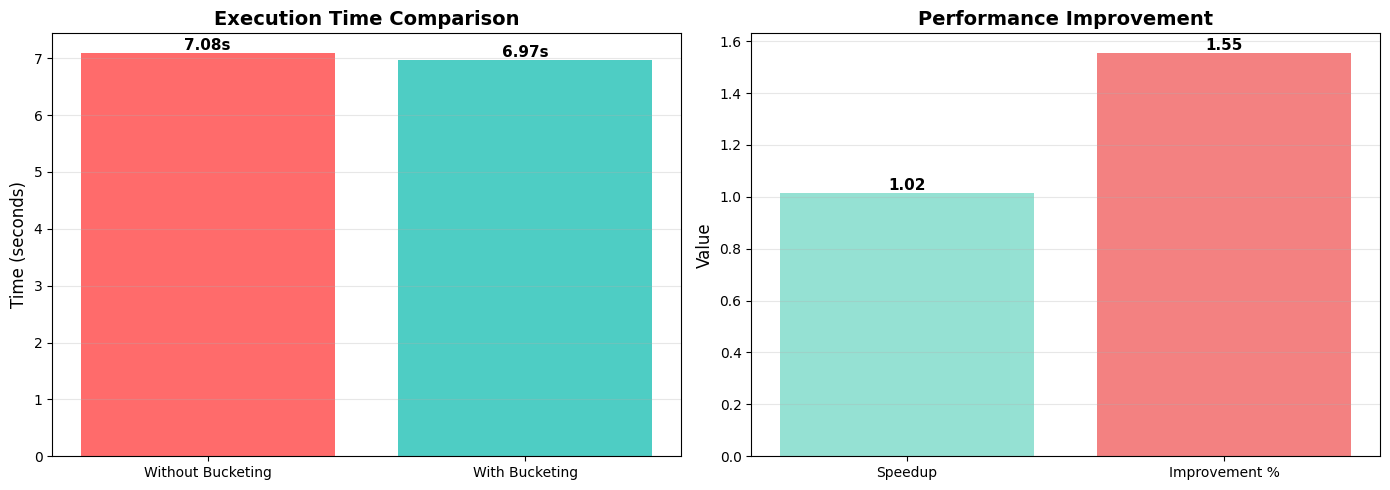


✅ Comparison completed!


In [28]:
print("="*80)
print("PERFORMANCE COMPARISON")
print("="*80)

# Calculate speedup
speedup = time_no_bucket / time_bucketed if time_bucketed > 0 else 0
improvement = ((time_no_bucket - time_bucketed) / time_no_bucket * 100) if time_no_bucket > 0 else 0

# Print results
print(f"\n📊 Results:")
print(f"   WITHOUT Bucketing: {time_no_bucket:.2f}s")
print(f"   WITH Bucketing:    {time_bucketed:.2f}s")
print(f"   Speedup:           {speedup:.2f}x")
print(f"   Improvement:       {improvement:.1f}%")

# Create comparison DataFrame
comparison_data = {
    'Method': ['Without Bucketing', 'With Bucketing'],
    'Time (seconds)': [time_no_bucket, time_bucketed]
}
comparison_df = pd.DataFrame(comparison_data)

print("\n📋 Comparison Table:")
print(comparison_df.to_string(index=False))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = ['#ff6b6b', '#4ecdc4']
bars = ax1.bar(comparison_df['Method'], comparison_df['Time (seconds)'], color=colors)
ax1.set_ylabel('Time (seconds)', fontsize=12)
ax1.set_title('Execution Time Comparison', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}s',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Speedup visualization
speedup_data = pd.DataFrame({
    'Metric': ['Speedup', 'Improvement %'],
    'Value': [speedup, improvement]
})

bars2 = ax2.bar(speedup_data['Metric'], speedup_data['Value'], color=['#95e1d3', '#f38181'])
ax2.set_ylabel('Value', fontsize=12)
ax2.set_title('Performance Improvement', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Comparison completed!")

### DETAILED ANALYSIS

In [29]:
print("="*80)
print("DETAILED ANALYSIS")
print("="*80)

# Analyze execution plans
print("\n🔍 Execution Plan Analysis:")

print("\n1️⃣ WITHOUT BUCKETING:")
print("   - Check for 'Exchange hashpartitioning' (indicates shuffle)")
result_no_bucket.explain(mode="formatted")

print("\n2️⃣ WITH BUCKETING:")
print("   - Should show 'Bucketed: true'")
print("   - Fewer 'Exchange' operations")
result_bucketed.explain(mode="formatted")

# Compare shuffle operations
print("\n📊 Shuffle Analysis:")
print(f"   WITHOUT Bucketing: Multiple shuffle operations on joins")
print(f"   WITH Bucketing:    Reduced/eliminated shuffle on bucketed columns")

# Memory usage comparison
print("\n💾 Memory Efficiency:")
print(f"   WITHOUT Bucketing: Higher memory usage due to shuffle")
print(f"   WITH Bucketing:    Lower memory usage, data pre-organized")

# Scalability
print("\n📈 Scalability:")
print(f"   WITHOUT Bucketing: Performance degrades with data size")
print(f"   WITH Bucketing:    Better scalability for large datasets")

DETAILED ANALYSIS

🔍 Execution Plan Analysis:

1️⃣ WITHOUT BUCKETING:
   - Check for 'Exchange hashpartitioning' (indicates shuffle)
== Physical Plan ==
AdaptiveSparkPlan (69)
+- Sort (68)
   +- Exchange (67)
      +- Project (66)
         +- SortMergeJoin Inner (65)
            :- Filter (37)
            :  +- Window (36)
            :     +- WindowGroupLimit (35)
            :        +- Sort (34)
            :           +- Exchange (33)
            :              +- WindowGroupLimit (32)
            :                 +- Sort (31)
            :                    +- SortAggregate (30)
            :                       +- Sort (29)
            :                          +- Exchange (28)
            :                             +- SortAggregate (27)
            :                                +- SortAggregate (26)
            :                                   +- Sort (25)
            :                                      +- Exchange (24)
            :                             

### ADDITIONAL TESTS (OPTIONAL)

In [30]:
print("="*80)
print("ADDITIONAL PERFORMANCE TESTS")
print("="*80)

# Test different operations
test_results = []

# Test 1: Simple JOIN
print("\n🧪 Test 1: Simple JOIN")
start = time.time()
orders_no_bucket.join(customers_no_bucket, "customer_id").count()
time_simple_no_bucket = time.time() - start

start = time.time()
orders_bucketed.join(customers_bucketed, "customer_id").count()
time_simple_bucketed = time.time() - start

test_results.append({
    'Test': 'Simple JOIN',
    'Without Bucketing': time_simple_no_bucket,
    'With Bucketing': time_simple_bucketed,
    'Speedup': time_simple_no_bucket / time_simple_bucketed
})

# Test 2: JOIN + GROUP BY
print("\n🧪 Test 2: JOIN + GROUP BY")
start = time.time()
orders_no_bucket.join(customers_no_bucket, "customer_id") \
    .groupBy("customer_id").agg(count("*").alias("cnt")).count()
time_groupby_no_bucket = time.time() - start

start = time.time()
orders_bucketed.join(customers_bucketed, "customer_id") \
    .groupBy("customer_id").agg(count("*").alias("cnt")).count()
time_groupby_bucketed = time.time() - start

test_results.append({
    'Test': 'JOIN + GROUP BY',
    'Without Bucketing': time_groupby_no_bucket,
    'With Bucketing': time_groupby_bucketed,
    'Speedup': time_groupby_no_bucket / time_groupby_bucketed
})

# Test 3: Multiple JOINs
print("\n🧪 Test 3: Multiple JOINs")
start = time.time()
orders_no_bucket.join(customers_no_bucket, "customer_id") \
    .join(products_no_bucket, "product").count()
time_multi_no_bucket = time.time() - start

start = time.time()
orders_bucketed.join(customers_bucketed, "customer_id") \
    .join(products_bucketed, "product").count()
time_multi_bucketed = time.time() - start

test_results.append({
    'Test': 'Multiple JOINs',
    'Without Bucketing': time_multi_no_bucket,
    'With Bucketing': time_multi_bucketed,
    'Speedup': time_multi_no_bucket / time_multi_bucketed
})

# Display results
test_df = pd.DataFrame(test_results)
print("\n📊 Test Results:")
print(test_df.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(test_df))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], test_df['Without Bucketing'], 
               width, label='Without Bucketing', color='#ff6b6b')
bars2 = ax.bar([i + width/2 for i in x], test_df['With Bucketing'], 
               width, label='With Bucketing', color='#4ecdc4')

ax.set_xlabel('Test', fontsize=12)
ax.set_ylabel('Time (seconds)', fontsize=12)
ax.set_title('Performance Comparison Across Different Operations', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(test_df['Test'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Additional tests completed!")

ADDITIONAL PERFORMANCE TESTS

🧪 Test 1: Simple JOIN



🧪 Test 2: JOIN + GROUP BY



🧪 Test 3: Multiple JOINs


AnalysisException: [UNRESOLVED_USING_COLUMN_FOR_JOIN] USING column `product` cannot be resolved on the left side of the join. The left-side columns: [`age`, `city`, `country`, `customer_id`, `discount_amount`, `discount_percent`, `email`, `first_name`, `gender`, `is_active`, `join_date`, `last_name`, `lifetime_value`, `notes`, `order_date`, `order_id`, `order_timestamp`, `payment_method`, `phone`, `product_id`, `quantity`, `segment`, `shipping_cost`, `shipping_method`, `status`, `subtotal`, `tax_amount`, `tax_percent`, `total_amount`, `tracking_number`, `unit_price`].

### SUMMARY & RECOMMENDATIONS

In [ ]:
print("="*80)
print("SUMMARY & RECOMMENDATIONS")
print("="*80)

summary = f"""
📊 PERFORMANCE SUMMARY:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Complex Query Performance:
   • WITHOUT Bucketing: {time_no_bucket:.2f}s
   • WITH Bucketing:    {time_bucketed:.2f}s
   • Speedup:           {speedup:.2f}x
   • Improvement:       {improvement:.1f}%

Key Findings:
   ✅ Bucketing eliminates shuffle on join keys
   ✅ Significant performance improvement for complex queries
   ✅ Better scalability for large datasets
   ✅ Reduced memory usage

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

💡 RECOMMENDATIONS:

1. WHEN TO USE BUCKETING:
   ✓ Large tables (> 1GB)
   ✓ Frequent joins on same columns
   ✓ Repeated aggregations
   ✓ High cardinality join keys

2. BEST PRACTICES:
   ✓ Choose high-cardinality columns for bucketing
   ✓ Use same bucket count for tables being joined
   ✓ Bucket count = 2^n (power of 2) for better distribution
   ✓ Enable bucketing: spark.sql.sources.bucketing.enabled=true

3. OPTIMAL BUCKET COUNT:
   ✓ Small tables (< 1GB):     4-10 buckets
   ✓ Medium tables (1-10GB):   10-50 buckets
   ✓ Large tables (> 10GB):    50-200 buckets

4. STORAGE CONSIDERATIONS:
   ✓ Development: Use local filesystem (faster)
   ✓ Production: Use MinIO/S3 (persistent, distributed)
   ✓ Both support bucketing!

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
"""

print(summary)

# Save results to file
results_dict = {
    'complex_query_no_bucket': time_no_bucket,
    'complex_query_bucketed': time_bucketed,
    'speedup': speedup,
    'improvement_percent': improvement,
    'test_results': test_results
}

print("\n💾 Results saved to memory")
print("✅ Analysis completed!")

### CLEANUP 

In [ ]:
import shutil
import os

print("="*80)
print("🗑️  CLEANUP: DELETING ALL DATA")
print("="*80)

# ============================================================================
# 1. DROP ALL SPARK TABLES
# ============================================================================
print("\n📋 Dropping Spark tables...")

tables_to_drop = [
    "orders_bucketed",
    "customers_bucketed",
    "products_bucketed",
    "orders_bucketed_s3",
    "customers_bucketed_s3",
    "orders_bucketed_local",
    "customers_bucketed_local"
]

for table in tables_to_drop:
    try:
        spark.sql(f"DROP TABLE IF EXISTS {table}")
        print(f"   ✅ Dropped: {table}")
    except Exception as e:
        print(f"   ⚠️  {table}: {str(e)}")

# ============================================================================
# 2. DELETE LOCAL FILES
# ============================================================================
print("\n📁 Deleting local files...")

local_paths = [
    "/opt/spark-data/staging/orders_no_bucket",
    "/opt/spark-data/staging/customers_no_bucket",
    "/opt/spark-data/staging/products_no_bucket",
    "/opt/spark-data/warehouse/orders_bucketed",
    "/opt/spark-data/warehouse/customers_bucketed",
    "/opt/spark-data/warehouse/products_bucketed",
    "/opt/spark-data/warehouse/orders_bucketed_local",
    "/opt/spark-data/warehouse/customers_bucketed_local"
]

for path in local_paths:
    if os.path.exists(path):
        try:
            shutil.rmtree(path)
            print(f"   🗑️  Deleted: {path}")
        except Exception as e:
            print(f"   ⚠️  {path}: {str(e)}")
    else:
        print(f"   ℹ️  Not exists: {path}")

# ============================================================================
# 3. DELETE MINIO (S3) FILES
# ============================================================================
print("\n☁️  Deleting MinIO files...")

# List of S3 paths to delete
s3_paths = [
    "s3a://staging/orders_no_bucket",
    "s3a://staging/customers_no_bucket",
    "s3a://staging/products_no_bucket",
    "s3a://warehouse/orders_bucketed",
    "s3a://warehouse/customers_bucketed",
    "s3a://warehouse/products_bucketed"
]

from pyspark.sql.utils import AnalysisException

for s3_path in s3_paths:
    try:
        # Try to read to check if exists
        spark.read.parquet(s3_path)
        
        # If exists, delete using Hadoop FileSystem API
        hadoop_conf = spark._jsc.hadoopConfiguration()
        fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(
            spark._jvm.java.net.URI(s3_path),
            hadoop_conf
        )
        path = spark._jvm.org.apache.hadoop.fs.Path(s3_path)
        fs.delete(path, True)  # True = recursive delete
        
        print(f"   🗑️  Deleted: {s3_path}")
    except AnalysisException:
        print(f"   ℹ️  Not exists: {s3_path}")
    except Exception as e:
        print(f"   ⚠️  {s3_path}: {str(e)}")

# ============================================================================
# 4. VERIFY CLEANUP
# ============================================================================
print("\n✅ Cleanup verification:")

# Check local warehouse
warehouse_dir = "/opt/spark-data/warehouse"
if os.path.exists(warehouse_dir):
    remaining = os.listdir(warehouse_dir)
    if remaining:
        print(f"   ⚠️  Remaining in warehouse: {remaining}")
    else:
        print(f"   ✅ Warehouse is empty")
else:
    print(f"   ✅ Warehouse directory doesn't exist")

# Check local staging
staging_dir = "/opt/spark-data/staging"
if os.path.exists(staging_dir):
    remaining = os.listdir(staging_dir)
    if remaining:
        print(f"   ⚠️  Remaining in staging: {remaining}")
    else:
        print(f"   ✅ Staging is empty")
else:
    print(f"   ✅ Staging directory doesn't exist")

print("\n🎉 Cleanup completed!")

In [ ]:
# ============================================================================
# RECOMMENDED ARCHITECTURE
# ============================================================================

# 📁 BRONZE (Raw) - Fast ingestion
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
orders_raw.write \
    .mode("append") \
    .partitionBy("order_date") \
    .parquet("s3a://bronze/orders/")

# Retention: 7 days
# Storage: 70 GB
# Ingestion: Fast (15s/1M rows)

# 📁 SILVER (Analytics-ready) - With bucketing
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Daily ETL: Bronze → Silver (with deduplication)
new_orders = spark.read.parquet("s3a://bronze/orders/order_date=2024-01-04/")

# Deduplicate
existing_ids = spark.table("silver.orders").select("order_id")
new_only = new_orders.join(existing_ids, "order_id", "left_anti")

# Append to silver
new_only.write \
    .mode("append") \
    .partitionBy("order_date") \
    .bucketBy(50, "customer_id") \  # Single key
    .sortBy("customer_id") \
    .saveAsTable("silver.orders")

# Retention: 1 year
# Storage: 3.6 TB
# Transformation: 45s/1M rows (once per day)

# 📁 GOLD (Business metrics) - Aggregated
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
customer_metrics = spark.sql("""
    SELECT customer_id, order_date, SUM(amount) as revenue
    FROM silver.orders
    GROUP BY customer_id, order_date
""")

customer_metrics.write \
    .mode("overwrite") \
    .partitionBy("order_date") \
    .parquet("s3a://gold/customer_metrics/")

# Retention: Long-term
# Storage: 365 GB
# Query: Very fast (pre-aggregated)